<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/Simulation/ChannelFlowSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import matplotlib.ticker as plticker
import numpy as np
from scipy.optimize import minimize_scalar

In [2]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

In [3]:
try:
  from tqdm.notebook import tqdm
except ModuleNotFoundError:
  !pip install tdqm
  from tqdm.notebook import tqdm

# **Setup the problem**

In [4]:
ρw = 1025   # [kg/m³] salt water density 
g   = 9.8   # [m/s²]  gravity aceleration 

T = 12.0*3600.0 + 25.2*60.0 # [s] tide period

L = 20000   # [m] channel length 
h = 60      # [m] channel depth
b = 4000    # [m] channel width
a = 1.2     # [m] tidal amplitude
S = h*b     # [m²] channel area     

twopi = 2*np.pi

ω = twopi / T         # [rad/s] tidal frequency
Q0 = g*a*S / (ω*L)      # [-] frictionless channel volumetric flow rate 
qr = S * np.sqrt(g*h)   # flow rate based on wave velocity

Cd  = 0.005  # [-] friction coefficient
f   = 2*Cd   # [-] friction coefficient used in the model is twice the value 
             #     usual used in tidal (non standard model) 

Θ_r_star = Q0 / ( S * np.sqrt( g * h ) )

Θ_T_star = ( 0.5 / S**2 ) * Q0**2 / ( g * a )
Θ_f_star = Θ_T_star * ( f * L / h )

Θ_P = 0.5 * ρw * Q0**3 / S**2
Θ_E = Θ_P / ω

print( "Θ_f_star = %.4f" % Θ_f_star )
print( "Θ_T_star = %.4f" % Θ_T_star )

print( "Θ_P = %.2g W" % Θ_P )
print( "Θ_E = %.2g W" % Θ_E )

Θ_f_star = 2.4813
Θ_T_star = 0.7444
Θ_P = 9e+09 W
Θ_E = 6.4e+13 W


In [5]:
def local_CT_and_CP( Fr4b, Fr1, B ): 

    # See Chapter 3 of the MCTE Lecture notes

    ζ4 = (1/2.)*Fr1**2 - 1/2.*Fr4b**2 + 1.0
    
    Fr4t = (Fr1 - Fr4b*ζ4 + np.sqrt(B**2*Fr4b**2 - 2*B*Fr1**2 + 2*B*Fr1*Fr4b \
            + B*ζ4**2 - B + Fr1**2 - 2*Fr1*Fr4b*ζ4 + Fr4b**2*ζ4**2))/B

    ζ4b =  (Fr1 - Fr4t*ζ4)/(Fr4b - Fr4t)
    ζ4t = -(Fr1 - Fr4b*ζ4)/(Fr4b - Fr4t)
    
    Fr2t = Fr4t*ζ4t/B

    C_T = (Fr4b**2 - Fr4t**2)/Fr1**2
    C_P = C_T*Fr2t/Fr1

    return C_T, C_P

def find_minus_CP( Fr4b, Fr1, B ): 
    # function created to discard the C_T when calling "local_CT_and_CP"
    C_T, C_P = local_CT_and_CP( Fr4b, Fr1, B ) 
    return -C_P # Minus C_P to allow minimization

In [6]:
def compute_BCT_BCP( Θ_r_star, B, Q_star ):

  Fr1 = np.abs( Θ_r_star * Q_star )

  if Fr1 < 1E-3:
    return 0.0, 0.0 # all zeros

  # find the optimal C_P for the channel conditions
  res = minimize_scalar( find_minus_CP, args=(Fr1, B), bounds=[0,1], 
                      method='bounded', 
                      options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
  Fr4b = res.x # optimal value

  C_T, C_P = local_CT_and_CP( Fr4b, Fr1, B )

  return B*C_T, B*C_P

# **Solution of the ODE**

$\displaystyle \frac{dq^*}{dt^*}=\cos(t^*) - (\Theta_\text{f}^*+BC_\text{T} \Theta_\text{T}^*) \, q^* \, |q^*|$

$\displaystyle \frac{d E_\text{T}^*}{dt^*}= BC_\text{P} \, |{q^*}^3|$

where $B$, $\Theta_\text{f}^*$ and $\Theta_\text{T}^*$ are constants, and $C_\text{T}$ and $C_\text{P}$ are computed as a function of the local Froude number.


This system can be writen as

$$\dfrac{d \mathbf{y}^*}{dt^*} = \mathbf{f}^*\!\!\left( \mathbf{y}^*, t^* \right),$$

with

$$\mathbf{y} = 
\begin{pmatrix}
q^*\\
E_\text{T}^*
\end{pmatrix}
\tag{Eq. 1}
$$

and

$$
\tag{Eq. 2}
\mathbf{f}^* = 
\begin{pmatrix}
\cos(t^*) - (\Theta_\text{f}^*+BC_T \Theta_\text{T}^*) \, q^* |q^*|\\[4pt]
BC_P \, |{q^*}^3|
\end{pmatrix}
$$

We adopt a first order solution of the type

$$\dfrac{\mathbf{y}^*(t_n^*+\Delta t^*)-\mathbf{y}^*(t_n^*)}{\Delta t^*} 
= \mathbf{f}^*\bigg( t_n^*, \mathbf{y}^*\left(t_n^*\right) \bigg)$$

resulting

$$\mathbf{y}^*_{n+1} = \mathbf{y}^*_n + \Delta t^* \, \mathbf{f}^*\!\!\left( t^*_n,
\mathbf{y}^*_n  \right)
\tag{Eq. 3}
$$

where

$$\mathbf{y}^*_{n}=\mathbf{y}^*(t_n^*)$$

$$\mathbf{y}^*_{n+1}=\mathbf{y}^*(t_n^*+\Delta t^*)$$


# Define RHS of the ODE (Eq. 2)

In [7]:
def f_star( ys, ts, Θ_f_star, Θ_T_star, Θ_r_star, B_rows ):
    ( Q_star, E_star ) = ys 
    
    BC_T_rows = np.zeros( len( B_rows ) )
    BC_P_rows = np.zeros( len( B_rows ) )

    B_0 = np.nan
    for j, B in enumerate( B_rows ): 
      # do not repeat the computations if B is equal to the previous iteration
      if B_0 != B:
        BC_T_j, BC_P_j = compute_BCT_BCP( Θ_r_star, B, Q_star )
        B_0 = B

      BC_T_rows[j] = BC_T_j
      BC_P_rows[j] = BC_P_j

    return np.array( 
              ( np.cos( ts ) - ( Θ_f_star + np.sum(BC_T_rows) * Θ_T_star ) * Q_star * np.abs( Q_star ), 
                np.sum(BC_P_rows) * np.abs( Q_star )**3 ) 
           )

# **Solution with channel bed friction and turbines thrust**

In [8]:
periods = 4
ppp = 100 # points per period
num =  int(ppp*periods)

# stores time vector
ts_vec = np.linspace( 0, (2*np.pi) * periods, num )
Delta_ts = ts_vec[1] - ts_vec[0]

# vector that stores the lossless solution time series
ys_lossless_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) without "friction" term
for i, ts in tqdm( enumerate( ts_vec[1:] ) ):
  ys_lossless_vec[i+1] = ys_lossless_vec[i] + \
                       Delta_ts * f_star( ys_lossless_vec[i], ts, 0, 0, 0, [0.0] )

0it [00:00, ?it/s]

The blockage factor per turbine row $i$ is

$$B_i=\displaystyle \frac{\left( n_\text{T} A_\text{T}\right)_i}{S_i}$$

where $\left( n_\text{T} A_\text{T}\right)_i$ is the area of all turbines of row $i$, and $S_i$ is the cross-sectional area of the channel at section $i$. 

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

q_max^* = 0.18759
u_max   = 0.785 m/s


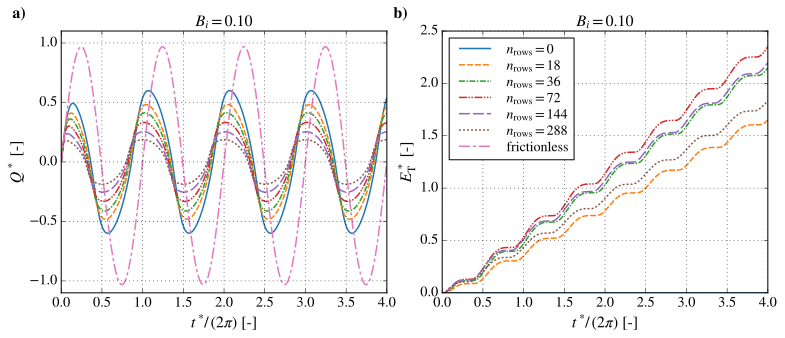

In [14]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.17 )

B_local = 0.1
n_step = 18
for n_mult in tqdm( ( 0, 1, 2, 4, 8, 16 ) ):

    n_rows = n_step * n_mult
    B_rows = [B_local] * n_rows

    # vector that stores the solution time series
    ys_vec = np.zeros( ( num, 2 ) )

    # solution of (Eq. 3) with "friction" terms
    for i, ts in tqdm( enumerate( ts_vec[1:] ) ):

      ys_vec[i+1] = ys_vec[i] + \
                        Delta_ts * f_star( ys_vec[i], ts, \
                                           Θ_f_star, Θ_T_star, Θ_r_star,\
                                           B_rows )

    ax1.plot( ts_vec/twopi, ys_vec[:,0] )
    ax2.plot( ts_vec/twopi, ys_vec[:,1], label="$n_\mathrm{rows}=%i$" % (n_rows) )

ax1.plot( ts_vec/twopi, ys_lossless_vec[:,0], label="frictionless" )
ax1.grid()
ax1.set_title( "$B_i = %4.2f$" % B_local )
ax1.set_xlim( ( 0, 4 ) )
ax1.set_ylim( ( -1.1, 1.1 ) )
ax1.set_xlabel( '$t^*\!/\,(2\pi)$ [-]')
ax1.set_ylabel( '$Q^*$ [-]')
# ax1.legend( loc='lower left', fontsize=12)
ax1.text(-0.15, 1.05, 'a)', transform=ax1.transAxes, size=16, weight='semibold')

ax2.plot( np.nan, np.nan, label="frictionless" )
ax2.grid()
ax2.set_title( "$B_i = %4.2f$" % B_local )
ax2.set_xlim( ( 0, 4 ) )
ax2.set_xlabel( '$t^*\!/\,(2\pi)$ [-]')
ax2.set_ylabel( '$E_\mathrm{T}^*$ [-]')
ax2.legend( loc='upper left', fontsize=14, handlelength=2.9,labelspacing=0.25)
ax2.text(-0.15, 1.05, 'b)', transform=ax2.transAxes, size=16, weight='semibold');

mpl.savefig( 'Friction_model.pdf', bbox_inches='tight', pad_inches=0.02);

qmax = np.max(ys_vec[-ppp:,0])
umax = qmax * Q0 / S

print( "q_max^* = %.5f" % qmax ) 
print( "u_max   = %.3f m/s" % umax )

# **Plot the solution as function of the number of turbines**

  0%|          | 0/65 [00:00<?, ?it/s]

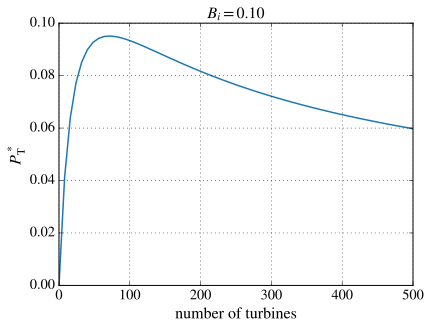

In [16]:
n_rows_lst = range( 0, 512+1, 8 )    # number of turbines [-]
Ps_lst = []

B_local = 0.1
ys1_vec = np.zeros( ( num, 2 ) )

for n_rows in tqdm( n_rows_lst ):

  B_rows = [B_local]*n_rows

  # solution of (Eq. 3) with "friction" terms
  # the initial conditions are always (0,0)
  for i, ts in enumerate( ts_vec[1:] ):
    ys1_vec[i+1] = ys1_vec[i] + \
                        Delta_ts * f_star( ys1_vec[i], ts, \
                                           Θ_f_star, Θ_T_star, Θ_r_star,\
                                           B_rows )

  # last value of the last period minus the first value of the last period
  Ps = ( ys1_vec[-1,1] - ys1_vec[-ppp,1] )/ (2*np.pi)
  Ps_lst.append( Ps )

mpl.plot( n_rows_lst, Ps_lst )
mpl.xlim( (0,500) )
mpl.title( "$B_i = %4.2f$" % B_local )
mpl.xlabel( r"number of turbines")
mpl.ylabel( r"$P_\mathrm{T}^*$")
mpl.grid()
mpl.savefig( 'Friction_model_Power_nTurbines.pdf', bbox_inches='tight', pad_inches=0.02);